# *Bước 1:* Tải xuống bộ dữ liệu SQuAD 2.0 và thư viện Transformers

In [4]:
%%capture
!pip install transformers

In [ ]:
%%capture
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering
import time
# Nhập các thư viện cần thiết

In [ ]:
# Kiểm tra xem có GPU không
is_cuda = torch.cuda.is_available()

# Nếu có GPU, đặt thiết bị là GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


*Stanford Question Answering Dataset* (SQuAD) bao gồm các câu hỏi (100.000) trên một tập các bài viết Wikipedia, trong đó câu trả lời cho mỗi câu hỏi là một đoạn văn bản từ đoạn đọc tương ứng. Ở phiên bản thứ hai của SQuAD, các câu hỏi không có đáp án (50.000) được thêm vào để giống với các câu hỏi có đáp án.

Mục đích của các hệ thống sử dụng bộ dữ liệu SQuAD2.0 là không chỉ trả lời các câu hỏi khi có thể, mà còn xác định khi nào không có đáp án phù hợp trong đoạn văn và từ chối trả lời.

In [7]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

# *Bước 2:* Lấy và lưu trữ dữ liệu

Ở đây tôi lấy và lưu trữ các đoạn văn, câu hỏi và đáp án từ các file .json train và validation. Nếu quan sát kỹ, ta sẽ thấy trong các file này có nhiều câu hỏi và đáp án cho mỗi đoạn văn. Tôi lưu các thông tin này vào các danh sách.

In [ ]:
# Định nghĩa đường dẫn đến dữ liệu huấn luyện SQuAD 2.0
path = "squad/train-v2.0.json"

# Tải và tiền xử lý dữ liệu SQuAD 2.0
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Tiền xử lý dữ liệu để tìm vị trí bắt đầu và kết thúc của đáp án
train_texts, train_queries, train_answers = load_squad_data(path)

In [ ]:
# Đưa đường dẫn cho dữ liệu validation SQuAD 2.0
path = Path('squad/dev-v2.0.json')

# Tải và tiền xử lý dữ liệu SQuAD 2.0
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Tiền xử lý dữ liệu để tìm vị trí bắt đầu và kết thúc của đáp án
val_texts, val_queries, val_answers = load_squad_data(path)

# *Bước 3:* Kiểm tra dữ liệu

In [ ]:
# In ra số lượng đoạn văn, câu hỏi, đáp án trong tập train
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [ ]:
# In ví dụ đầu tiên của tập train
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
# In ra số lượng đoạn văn, câu hỏi, đáp án trong tập validation
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20302
20302
20302


In [ ]:
# In ví dụ đầu tiên của tập validation
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


# *Bước 4:* Tìm vị trí bắt đầu và kết thúc của đáp án trong đoạn văn

In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Lấy chỉ số kết thúc thực tế
    end_idx = start_idx + len(real_answer)

    # Xử lý trường hợp lệch 1 hoặc 2 ký tự
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # Khi đáp án thực tế lệch 1 ký tự
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # Khi đáp án thực tế lệch 2 ký tự
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Lấy chỉ số kết thúc thực tế
    end_idx = start_idx + len(real_answer)

    # Xử lý trường hợp lệch 1 hoặc 2 ký tự
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # Khi đáp án thực tế lệch 1 ký tự
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # Khi đáp án thực tế lệch 2 ký tự
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2


# *Bước 5:* Tokenize các đoạn văn và câu hỏi

In [ ]:
from transformers import AutoTokenizer
# Khởi tạo tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [17]:
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

# *Bước 6:* Chuyển vị trí bắt đầu-kết thúc sang vị trí token

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    
    count = 0
    
    for i in range(len(answers)):
        # Lấy vị trí bắt đầu token
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        # Lấy vị trí kết thúc token
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
        
        # nếu vị trí bắt đầu là None, đoạn đáp án đã bị cắt bớt
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
            
        # nếu vị trí kết thúc là None, hàm 'char_to_token' trỏ đến ký tự sau token đúng, nên trừ đi 1
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
            
            # nếu vẫn None thì đáp án đã bị cắt bớt
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length
    print(count)
    
    # Cập nhật dữ liệu vào dictionary
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

10
16


Tôi nhận thấy sau khi tokenize, vị trí kết thúc đôi khi vẫn là None. Điều này chỉ xảy ra với 10 đáp án trong tập train (trên tổng số 86821) và 16 đáp án trong tập validation (trên tổng số 20302). Vì vậy tôi quyết định dịch đáp án sang trái 1 vị trí. Nếu vẫn là None thì tôi gán bằng model_max_length như trước. Tôi cũng đã thử kiểm tra nếu đáp án lệch phải 1 vị trí (cộng 1 vào vị trí kết thúc) hoặc lệch trái/phải 2 vị trí (+/- 2), nhưng số đáp án vẫn là None lại nhiều hơn (526), trong khi với cách này chỉ còn 10. Do đó tôi giữ chiến lược này để giảm số đáp án bị "bỏ qua".

# *Bước 7:* Tạo lớp Dataset

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # Lấy một phần tử theo chỉ số
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        # Trả về số lượng phần tử
        return len(self.encodings.input_ids)

In [ ]:
# Tạo dataset cho train và validation
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

# *Bước 8:* Sử dụng DataLoader

In [ ]:
# Khởi tạo DataLoader cho train và validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# *Bước 9:* Sử dụng GPU

In [ ]:
# Đặt thiết bị là GPU nếu có, ngược lại dùng CPU
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

# *Bước 10:* Xây dựng mô hình Bert

Tôi chọn BertForQuestionAnswering từ thư viện transformers vì nó phù hợp nhất với bài toán này. Khi khởi tạo mô hình với from_pretrained(), cấu hình và trọng số đã huấn luyện trước của mô hình sẽ được sử dụng để khởi tạo. Ngoài ra, tôi sử dụng optimizer AdamW của PyTorch, có khả năng hiệu chỉnh gradient và giảm trọng số.

In [ ]:
# Khởi tạo mô hình Bert cho bài toán trả lời câu hỏi
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

In [ ]:
from transformers import AdamW
# Khởi tạo optimizer AdamW
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 3

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# *Bước 11:* Huấn luyện và đánh giá mô hình

In [ ]:
# Đo thời gian huấn luyện và đánh giá tổng thể
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
    epoch_time = time.time()
    
    # Đặt mô hình ở chế độ huấn luyện
    model.train()
    loss_of_epoch = 0
    
    print("############Train############")
    
    for batch_idx,batch in enumerate(train_loader): 
        optim.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # lan truyền ngược
        loss.backward()
        # cập nhật trọng số
        optim.step()
        # Tính tổng loss
        loss_of_epoch += loss.item()
        
        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")
        
    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)
    
    ##########Đánh giá##################
    
    # Đặt mô hình ở chế độ đánh giá
    model.eval()
    
    print("############Evaluate############")
    
    loss_of_epoch = 0
    
    for batch_idx,batch in enumerate(val_loader):
        
        with torch.no_grad():
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Tính tổng loss
            loss_of_epoch += loss.item()
            
        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")
    
    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)
    
    # In thời gian và loss của mỗi epoch
    
    print("\n-------Epoch ", epoch+1,
          "-------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ",(time.time() - epoch_time),
          "\n-----------------------",
          "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 10853 
Loss: 1.7 

Batch 2000 / 10853 
Loss: 1.6 

Batch 3000 / 10853 
Loss: 0.9 

Batch 4000 / 10853 
Loss: 1.5 

Batch 5000 / 10853 
Loss: 1.2 

Batch 6000 / 10853 
Loss: 0.9 

Batch 7000 / 10853 
Loss: 0.9 

Batch 8000 / 10853 
Loss: 1.0 

Batch 9000 / 10853 
Loss: 2.1 

Batch 10000 / 10853 
Loss: 0.3 

############Evaluate############
Batch 1000 / 2538 
Loss: 2.0 

Batch 2000 / 2538 
Loss: 0.6 


-------Epoch  1 -------
Training Loss: 1.3305625837142814 
Validation Loss: 1.1514507515562906 
Time:  9507.142520189285 
----------------------- 


############Train############
Batch 1000 / 10853 
Loss: 1.1 

Batch 2000 / 10853 
Loss: 0.8 

Batch 3000 / 10853 
Loss: 1.5 

Batch 4000 / 10853 
Loss: 1.2 

Batch 5000 / 10853 
Loss: 1.5 

Batch 6000 / 10853 
Loss: 0.3 

Batch 7000 / 10853 
Loss: 0.5 

Batch 8000 / 10853 
Loss: 1.6 

Batch 9000 / 10853 
Loss: 0.5 

Batch 10000 / 10853 
Loss: 0.5 

############Evaluate############
Batch 1000 / 2538 
L

# *Bước 12:* Vẽ biểu đồ loss train và validation

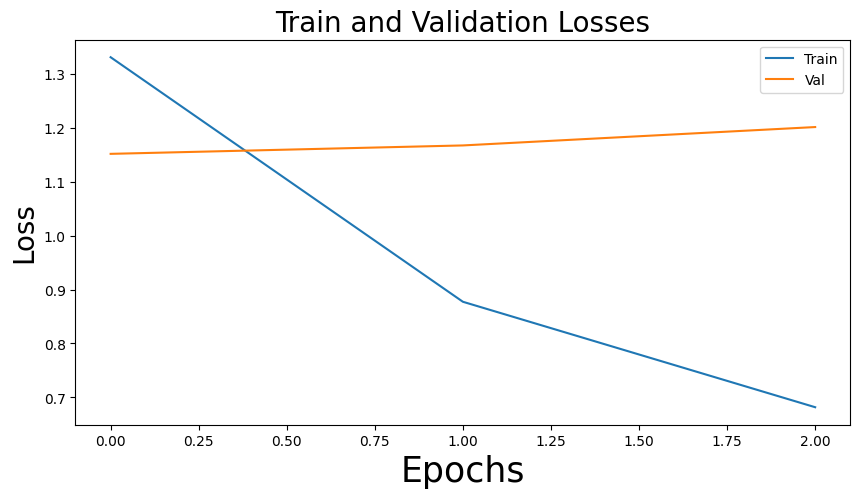

In [ ]:
import matplotlib.pyplot as plt 

# Vẽ biểu đồ loss train và validation
gig,ax = plt.subplots(1,1,figsize=(10,5))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

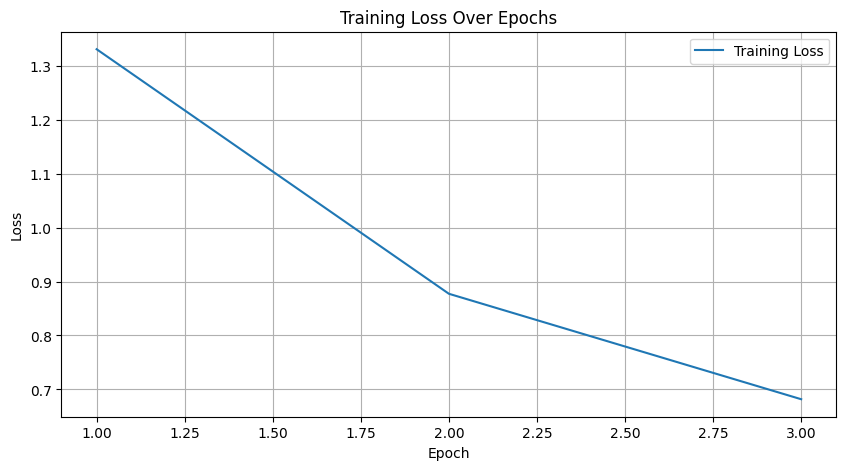

In [ ]:
# Vẽ biểu đồ loss huấn luyện
gig,ax = plt.subplots(1,1,figsize=(10,5))
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

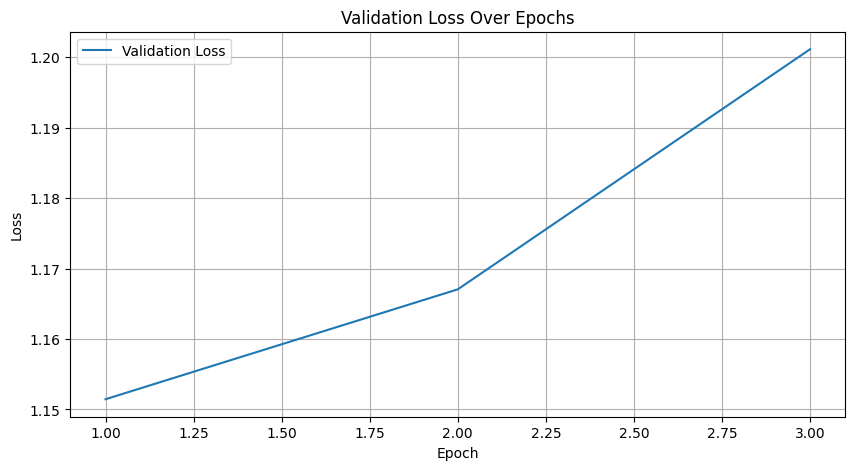

In [ ]:
# Vẽ biểu đồ loss validation
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

**Tóm tắt quá trình huấn luyện mô hình:**
Tôi phải nói rằng tôi đã phải chờ nhiều giờ để chạy toàn bộ notebook (có lúc ~9 tiếng) và đó là một quá trình rất mệt mỏi, vì đôi khi sau 8 tiếng thì phiên làm việc trên kaggle bị ngắt kết nối hoặc GPU bị hết. Điều tôi rút ra là việc huấn luyện mô hình rất tốn thời gian và cần máy tính mạnh.

Tuy nhiên, tôi đã chạy được với một số siêu tham số mà tôi muốn để đạt hiệu suất tốt nhất. Tôi tham khảo các bài giảng về BERT để chọn giá trị thử nghiệm. Cụ thể:

**Batch size:** 8, 16

**Learning rate (Adam):** 5e−5, 3e−5, 2e−5

**Số epoch:** 2, 3, 4

Tôi sẽ phân tích kỹ hơn sau, nhưng cuối cùng tôi giữ các giá trị *batch size 8, 3 epoch* và *learning rate 5e-5* là tối ưu.

# *Bước 13:* Lưu mô hình đã huấn luyện

In [ ]:
# Lưu mô hình vào Google Drive
torch.save(model, '/kaggle/working/bert_finetunedmodel')

# *Bước 14:* Tải mô hình đã huấn luyện

In [ ]:
# Tải mô hình đã lưu
bert_model2 = torch.load('/kaggle/working/bert_finetunedmodel',map_location=torch.device('cpu'))
bert_model2.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

# *Bước 15:* Dự đoán và đánh giá kết quả

In [ ]:
def predict(context,query):
    # Hàm dự đoán trả lời câu hỏi
    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = bert_model2(**inputs)
    answer_start = torch.argmax(outputs[0])  # lấy vị trí bắt đầu có xác suất cao nhất
    answer_end = torch.argmax(outputs[1]) + 1 
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Loại bỏ mạo từ, dấu câu và chuẩn hóa khoảng trắng là các bước xử lý văn bản phổ biến."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    
    def white_space_fix(text):
        return " ".join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    # Tính điểm exact match
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    # Tính điểm F1
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # nếu một trong hai là không có đáp án thì F1 = 1 nếu giống nhau, ngược lại là 0
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # nếu không có token chung thì F1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):
    # Hàm in ra dự đoán và điểm số
    prediction = predict(context,query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    print(f"EM: {em_score}")
    print(f"F1: {f1_score}")
    print("\n")

# *Bước 16:* Kiểm tra mô hình đã huấn luyện

Ở đây tôi đưa ra một số ví dụ cho mô hình BERT đã huấn luyện trên bộ dữ liệu SQuAD 2.0 để xem mô hình hoạt động tốt như thế nào. Tôi bắt đầu với các ví dụ đơn giản rồi đến các ví dụ phức tạp hơn.

Với các bài toán QA trích xuất văn bản, thường sử dụng hai chỉ số đánh giá là ***exact match*** và ***F1 score***.

***Exact Match***: kiểm tra xem đáp án dự đoán có khớp hoàn toàn với đáp án đúng không. Nếu khớp thì cho 1.0, ngược lại là 0.0.

***F1 Score***: tính trung bình số từ trùng giữa đáp án dự đoán và đáp án đúng, đảm bảo tối ưu cả độ chính xác và độ bao phủ.

**Như bạn thấy, mô hình của tôi dự đoán đúng tất cả đáp án ở ví dụ đơn giản.**

In [36]:
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = ["How old is Alexa?",
           "Where does Alexa live now?",
           "Where Alexa used to live?"
          ]
answers = ["21",
           "Kaisariani of Athens",
           "Peristeri of Athens"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)


Question: How old is Alexa?
Prediction: 21
True Answer: 21
EM: 1
F1: 1.0


Question: Where does Alexa live now?
Prediction: kaisariani
True Answer: Kaisariani of Athens
EM: 0
F1: 0.5


Question: Where Alexa used to live?
Prediction: peristeri of athens,
True Answer: Peristeri of Athens
EM: 1
F1: 1.0




In [37]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano), 
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced 
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly 
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 1970.
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction: freddie mercury ( lead vocals, piano ), brian may ( guitar, vocals ), roger taylor ( drums, vocals ) and john deacon ( bass ).
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.6923076923076924


Question: What kind of band they are?
Prediction: rock
True Answer: rock
EM: 1
F1: 1.0




In [39]:
context = """ Mount Olympus is the highest mountain in Greece. It is part of the Olympus massif near 
              the Gulf of Thérmai of the Aegean Sea, located in the Olympus Range on the border between 
              Thessaly and Macedonia, between the regional units of Pieria and Larissa, about 80 km (50 mi) 
              southwest from Thessaloniki. Mount Olympus has 52 peaks and deep gorges. The highest peak, 
              Mytikas, meaning "nose", rises to 2917 metres (9,570 ft). It is one of the 
              highest peaks in Europe in terms of topographic prominence. """

queries = [
           "How many metres is Olympus?",
           "Where Olympus is near?",
           "How far away is Olympus from Thessaloniki?"
          ]
answers = [
           "2917",
           "Gulf of Thérmai of the Aegean Sea",
           "80 km (50 mi)"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: How many metres is Olympus?
Prediction: 
True Answer: 2917
EM: 0
F1: 0


Question: Where Olympus is near?
Prediction: gulf of thermai of the aegean sea,
True Answer: Gulf of Thérmai of the Aegean Sea
EM: 0
F1: 0.6666666666666666


Question: How far away is Olympus from Thessaloniki?
Prediction: 80 km
True Answer: 80 km (50 mi)
EM: 0
F1: 0.6666666666666666




In [41]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19) 
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China. 
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic 
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are 
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. 
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           " "
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction: coronavirus disease 2019
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 0
F1: 0.6666666666666666


Question: What is caused by COVID-19?
Prediction: severe acute respiratory syndrome coronavirus 2
True Answer: severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
EM: 0
F1: 0.923076923076923


Question: How many cases have been confirmed from COVID-19?
Prediction: more than 105 million
True Answer: more than 105 million cases
EM: 0
F1: 0.888888888888889


Question: How many deaths have been confirmed from COVID-19?
Prediction: 2. 3 million
True Answer: more than 2.3 million deaths
EM: 0
F1: 0.25


Question: How is COVID-19 spread?
Prediction: mainly through the air when people are near each other.
True Answer: mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contamina

In [42]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: Who wrote Harry Potter's novels?
Prediction: j. k. rowling.
True Answer: J. K. Rowling
EM: 1
F1: 1.0


Question: Who are Harry Potter's friends?
Prediction: hermione granger and ron weasley,
True Answer: Hermione Granger and Ron Weasley
EM: 1
F1: 1.0


Question: Who is the enemy of Harry Potter?
Prediction: j. k. rowling.
True Answer: Lord Voldemort
EM: 0
F1: 0


Question: What are Muggles?
Prediction: non - magical people )
True Answer: non-magical people
EM: 0
F1: 0.4


Question: Which is the name of Harry Poter's first novel?
Prediction: 
True Answer: Harry Potter and the Philosopher's Stone
EM: 0
F1: 0


Question: When did the first novel release?
Prediction: 26 june 1997,
True Answer: 26 June 1997
EM: 1
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Prediction: j. k. rowling. the novels chronicle the lives of a young wizard, harry potter, and his friends hermione granger and ron weasley,
True Answer: a wide adult audience as well as younger readers
EM: 0
F

# *Bước 17:* Kiểm tra mô hình BERT đã huấn luyện sẵn

In [ ]:
# Khởi tạo tokenizer cho bert
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Tải mô hình đã fine-tune
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

In [ ]:
def predict(context,query):
    # Hàm dự đoán trả lời câu hỏi
    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = model(**inputs)
    answer_start = torch.argmax(outputs[0])  # lấy vị trí bắt đầu có xác suất cao nhất
    answer_end = torch.argmax(outputs[1]) + 1 
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Loại bỏ mạo từ, dấu câu và chuẩn hóa khoảng trắng là các bước xử lý văn bản phổ biến."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    
    def white_space_fix(text):
        return " ".join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    # Tính điểm exact match
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    # Tính điểm F1
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # nếu một trong hai là không có đáp án thì F1 = 1 nếu giống nhau, ngược lại là 0
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # nếu không có token chung thì F1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):
    # Hàm in ra dự đoán và điểm số
    prediction = predict(context,query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    print(f"EM: {em_score}")
    print(f"F1: {f1_score}")
    print("\n")

In [47]:
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = ["How old is Alexa?",
           "Where does Alexa live now?",
           "Where Alexa used to live?"
          ]
answers = ["21",
           "Kaisariani of Athens",
           "Peristeri of Athens"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: How old is Alexa?
Prediction: 21
True Answer: 21
EM: 1
F1: 1.0


Question: Where does Alexa live now?
Prediction: kaisariani of athens
True Answer: Kaisariani of Athens
EM: 1
F1: 1.0


Question: Where Alexa used to live?
Prediction: peristeri of athens
True Answer: Peristeri of Athens
EM: 1
F1: 1.0




In [48]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano), 
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced 
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly 
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 1970
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction: freddie mercury ( lead vocals, piano ), brian may ( guitar, vocals ), roger taylor ( drums, vocals ) and john deacon ( bass )
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.6923076923076924


Question: What kind of band they are?
Prediction: british rock
True Answer: rock
EM: 0
F1: 0.6666666666666666




In [49]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19) 
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China. 
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic 
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are 
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. 
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           " "
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction: an ongoing pandemic of coronavirus disease 2019
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 1
F1: 1.0


Question: What is caused by COVID-19?
Prediction: coronavirus disease 2019
True Answer: severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
EM: 0
F1: 0.2


Question: How many cases have been confirmed from COVID-19?
Prediction: more than 105 million
True Answer: more than 105 million cases
EM: 0
F1: 0.888888888888889


Question: How many deaths have been confirmed from COVID-19?
Prediction: 2. 3 million
True Answer: more than 2.3 million deaths
EM: 0
F1: 0.25


Question: How is COVID-19 spread?
Prediction: through the air when people are near each other
True Answer: mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.
EM: 0
F1: 0.35555555555

In [50]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: Who wrote Harry Potter's novels?
Prediction: j. k. rowling
True Answer: J. K. Rowling
EM: 1
F1: 1.0


Question: Who are Harry Potter's friends?
Prediction: hermione granger and ron weasley
True Answer: Hermione Granger and Ron Weasley
EM: 1
F1: 1.0


Question: Who is the enemy of Harry Potter?
Prediction: lord voldemort
True Answer: Lord Voldemort
EM: 1
F1: 1.0


Question: What are Muggles?
Prediction: non - magical people
True Answer: non-magical people
EM: 0
F1: 0.4


Question: Which is the name of Harry Poter's first novel?
Prediction: harry potter and the philosopher ' s stone
True Answer: Harry Potter and the Philosopher's Stone
EM: 0
F1: 0.7272727272727272


Question: When did the first novel release?
Prediction: 26 june 1997
True Answer: 26 June 1997
EM: 1
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Prediction: wide adult audience as well as younger readers
True Answer: a wide adult audience as well as younger readers
EM: 1
F1: 0.875


Question: How m

# *Bước 18:* Tổng kết

Tôi nhận thấy, nhìn chung với các câu hỏi có chứa từ hoặc cụm từ xuất hiện trong đoạn văn thì mô hình trả lời rất tốt.
Đôi khi với các câu hỏi phức tạp hoặc không rõ ràng, mô hình vẫn cho kết quả khá ổn.
Với việc tôi chỉ huấn luyện mô hình trong 3 epoch và không kiểm soát overfitting, kết quả đạt được là rất tốt.
Tôi cũng so sánh kết quả với mô hình đã fine-tune sẵn "bert-large-uncased-whole-word-masking-finetuned-squad".

In [ ]:
# Lưu mô hình vào Google Drive
torch.save(model, '/kaggle/working/bert_finetunedmodel')

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

# Hàm nén file và tạo link tải
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
# Tải file mô hình đã lưu
download_file('/kaggle/working/bert_finetunedmodel', 'bert_finetunedmodel')


/kaggle/working/bert_finetunedmodel.zip